# QAOA Max Cut

Wayne Nixalo – 2018/6/7

---

In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [17]:
import numpy as np
import matplotlib.pyplot as plt
import itertools

In [59]:
import networkx as nx

from grove.pyqaoa.qaoa import QAOA
from grove.pyqaoa.maxcut_qaoa import maxcut_qaoa
from pyquil.paulis import PauliSum, PauliTerm
from pyquil.gates import H
from pyquil.api import QVMConnection
import pyquil.quil as pq

from functools import reduce
from collections import Counter

In [4]:
display_options = {'node_color' :"#6CAFB7",
                   'node_size'  :250,
                   'with_labels': True}

## 'Classical' Solver

Low-level worker functions

In [19]:
def internal_edge(edge, graph):
    """Checks if edge is internal to graph."""
    return edge in graph.edges

def single_endpoint(edge, graph):
    """Checks that an edge has a single endpoint in graph."""
    return list(graph.edges()).count(edge) == 1

def get_edges_from_nodes(nodes, graph):
    """Retreives all edges connected to nodes in graph."""
    edges = []
    for node in nodes:
        for edge in graph.edges:
            if node in edge:
                edges.append(edge)
    return edges

def edges_between(edges_A, edges_B):
    """Gets the number of edges shared by edges_A and edges_B."""
    count = 0
    for edge in edges_A:
        count += set(edge) in map(set, edges_B)
    return count

def get_unique_permutations(nodes, split_idx):
    """Returns all unique combinations of nodes split at split_idx."""
    nodes_A,nodes_B = [],[]
    nodes = list(nodes)
    # get all unique combos up to the split
    for perm in itertools.permutations(nodes, split_idx+1):
        if set(perm) not in nodes_A: nodes_A.append(set(perm))
    # cast the sets back to lists
    nodes_A = list(map(list, nodes_A))
    # get all unique combos after the split
    for perm in nodes_A:
        add_nodes = nodes.copy()
        for node in perm: 
            add_nodes.remove(node)
        nodes_B.append(add_nodes)
    # return permutations of split pairs
    return nodes_A, nodes_B

Validation

In [20]:
def valid_cut(nodes_AB, edges_AB, graph):
    """Determines if a cut is valid."""
    
    nodes_A, nodes_B = nodes_AB
    edges_A, edges_B = edges_AB
    valid_cut = True
    
    # get edges of cut
    edges_A = get_edges_from_nodes(nodes_A, graph)
    edges_B = get_edges_from_nodes(nodes_B, graph)

    # check no internal edges
    A_internal = graph.copy()
    B_internal = graph.copy()
    A_internal.remove_nodes_from(nodes_B)
    B_internal.remove_nodes_from(nodes_A)
    
    for graph in (A_internal, B_internal): 
        if len(graph.edges) > 0: 
            valid_cut = False
            break

    # check all single endpoints – (check first no internals)
    if valid_cut: valid_cut = set(edges_B)==set(edges_A)
        
    return valid_cut

Finder

In [21]:
def find_max_cut(graph):
    """Finds the Max Cut of a Bipartite Graph."""
    max_crossed = 0

    # get cut splits
    n_nodes = len(graph.nodes)
    split_idxs = list(range(0, int(n_nodes//2)))

    # iterate through all unique cut sizes
    for split_idx in split_idxs:
        permutations = get_unique_permutations(graph.nodes, split_idx)

        # iterate through all unique node permutations (Select Cut)
        for nodes_A, nodes_B in list(zip(*permutations)):

            # get edges of cut
            edges_A = get_edges_from_nodes(nodes_A, graph)
            edges_B = get_edges_from_nodes(nodes_B, graph)

            # check no internal edges and check all single endpoints
            if not valid_cut((nodes_A, nodes_B), (edges_A, edges_B), graph):
                continue

            # count crossed edges
            count = edges_between(edges_A, edges_B)
            if count > max_crossed:
                max_crossed = count
                max_cut = [nodes_A, nodes_B]
                
    # check max cut exists
    if max_crossed == 0:
        max_cut = [None, None]
    
    return max_crossed, max_cut

## Example run:

8 [['x', 'w'], ['u', 'v', 'y', 'z']]
CPU times: user 34.2 ms, sys: 2.72 ms, total: 36.9 ms
Wall time: 36.4 ms


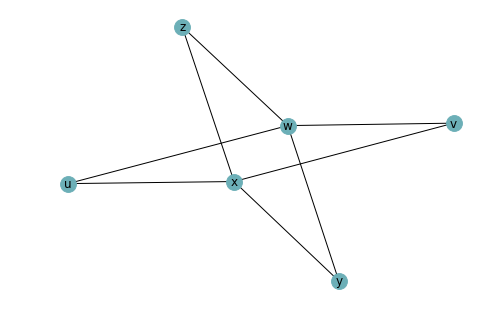

In [23]:
%%time

# create graph
g = nx.Graph()
g.add_nodes_from("uvwxyz")
edges = [('u','x'),('u','w'),('v','w'),('v','x'),
         ('y','w'),('y','x'),('z','w'),('z','x')]
g.add_edges_from(edges)

# find max cut
max_crossed, max_cut = find_max_cut(g)

# display
print(f"{max_crossed} {max_cut}")
nx.draw(g, **display_options)

## 'Quantum' Solver

In [25]:
# graph         = [(0,1)] # graph defined by list of unit-weight edges
steps         = 1  # reference to cost Hamiltonian evolution path length
qaoa_instance = maxcut_qaoa(graph, steps=steps)

Cost & Driver Hamiltonians corresponding to graph are stored as lists of PauliSums.

In [27]:
cost_list,ref_list = qaoa_instance.cost_ham, qaoa_instance.ref_ham
cost_ham = reduce(lambda x,y : x + y, cost_list)
ref_ham  = reduce(lambda x,y : x + y, ref_list)

Precompute Quil program

In [ ]:
param_program = qaoa_instance.get_parameterized_program()

Setup Rigetti Forest API connection

In [39]:
q_sim = QVMConnection()

In [41]:
n = 6
graph = nx.Graph()
for i in range(n): graph.add_edge(i, (i + 1) % n)

In [ ]:
# g = nx.Graph()
# g.add_nodes_from("uvwxyz")
# edges = [('u','x'),('u','w'),('v','w'),('v','x'),
#          ('y','w'),('y','x'),('z','w'),('z','x')]
# g.add_edges_from(edges)

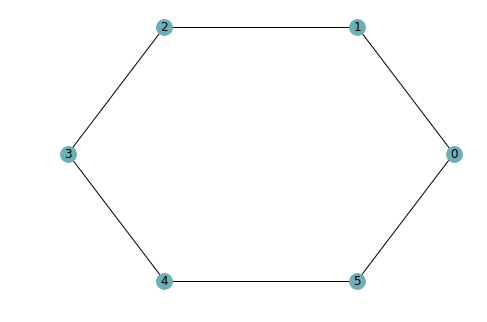

In [43]:
nx.draw_circular(graph, **display_options)

In [46]:
find_max_cut(graph)

(6, [[0, 2, 4], [1, 3, 5]])

`u`, `v`, `node` must all be integers to serve as indices. A dictionary will be needed to map non-integer nodes  & edge names.

In [106]:

# node_dict = {'u':0,'v':1,'w':2,'x':3,'y':4,'z':5}
graph = nx.Graph()
# g.add_nodes_from("uvwxyz")
graph.add_nodes_from([0,1,2,3,4,5])
edges = [(0,3),(0,2),(1,2),(1,3),
         (4,2),(4,3),(5,2),(5,3)]
graph.add_edges_from(edges)

In [107]:
graph.nodes, graph.edges

(NodeView((0, 1, 2, 3, 4, 5)),
 EdgeView([(0, 3), (0, 2), (1, 2), (1, 3), (2, 4), (2, 5), (3, 4), (3, 5)]))

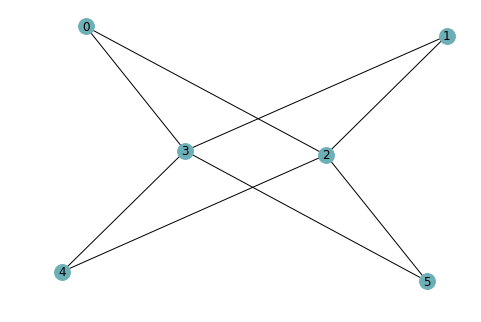

In [110]:
nx.draw(graph, **display_options)

In [111]:
cost_operators, driver_operators = [],[]

for u,v in graph.edges():
    cost_operators.append(PauliTerm("Z", u, 0.5) *
                          PauliTerm("Z", v)      +
                          PauliTerm("I", 0, -0.5))
for node in graph.nodes():
    driver_operators.append(PauliSum([PauliTerm("X", node, 1.0)]))

In [112]:
program = pq.Program()
for node in graph.nodes():
    program.inst(H(node))

In [113]:
max_cut_instance = QAOA(qvm=q_sim, n_qubits=len(graph.nodes()), steps=1, 
            ref_hamiltonian=driver_operators, cost_ham=cost_operators,
            driver_ref=program, store_basis=True)

In [114]:
betas, gammas = max_cut_instance.get_angles()

                     models will be ineffective
Optimization terminated successfully.
         Current function value: -5.574295
         Iterations: 23
         Function evaluations: 44


In [115]:
# get paramaterized program
param_program = max_cut_instance.get_parameterized_program()
sampling_program = param_program(np.hstack((betas, gammas)))

# use run_and_measure QVM API to prepare circuit & measure qubits
bitstring_samples = q_sim.run_and_measure(quil_program=sampling_program,
                        qubits=range(len(graph.nodes())), trials=1000)
bitstring_tuples  = map(tuple, bitstring_samples)

# aggregate statistics
freq = Counter(bitstring_tuples)
max_freq_string = max(freq, key=lambda x: freq[x])

In [116]:
for bit_string_freq in freq.items():
    if bit_string_freq[1] == max(freq.values()):
        max_cut = bit_string_freq

In [117]:
max_cut

((1, 1, 0, 0, 1, 1), 146)